# Does layer predict cell misses?

author: steeve.laquitaine@epfl.ch

modified: 03.06.2023

Setup environment: 

```bash
pip install requirements_kilosort_silico
```

### Setup

In [44]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

proj_path = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(proj_path)

from src.nodes.postpro.cell_matching import get_missed_units, get_detected_units, get_SpikeInterface_matching_object, match_sorted_to_true_neuropixels_2023_02_19
from src.nodes.utils import get_config
# from src.nodes.postpro.cell_matching import match_firing_rate, match_property
from src.nodes.postpro import feateng

# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"


# GET RUN CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()

CELL_MATCHING_PATH = data_conf["postprocessing"]["cell_matching"]

LOW_RATE_CEILING = 0.2  # max firing rate where negative proba change is observed in "bias plot"
MID_RATE_CEILING = 1    # max firing rate where positive proba change is observed in "bias plot"

# SET PATHS

# set Kilosort sorted spikes and cells path
KS3_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort3"]["output"]

# set ground truth spikes and cells path
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-06-03 20:32:12,005 - root - utils.py - get_config - INFO - Reading experiment config.
2023-06-03 20:32:12,126 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Setup custom functions

In [70]:
def plot_miss_by_x(n_missed_per_layer, n_total_per_layer, ylabel:str, figsize:tuple=(6, 2)):

    # build histo dataset
    df = pd.DataFrame(
        {
            "detected": n_total_per_layer - n_missed_per_layer,
            "missed": n_missed_per_layer,
        },
        index=list(n_missed_per_layer.index),
    )
    df_total = df["missed"] + df["detected"]
    df_rel = df.div(df_total, 0) * 100

    # set figure
    fig, axis = plt.subplots(1, 1, figsize=figsize)

    # set plot legend
    colors = ["w", [0.3, 0.3, 0.3],]

    # plot
    ax = df_rel.plot.barh(
        ax=axis,
        stacked=True,
        color=colors,
        width=0.9,
        edgecolor="k",
        linewidth=0.6,
    )

    # set axis legend
    ax.spines[["left", "right", "top"]].set_visible(False)
    x_axis = ax.axes.get_xaxis()
    x_axis.set_visible(True)
    ax.invert_yaxis()
    ax.set_xlabel("true units (count)", fontsize=9)
    ax.set_ylabel(ylabel, fontsize=9)
    ax.legend(
        bbox_to_anchor=(1, 1),
        frameon=False,
        fontsize=9,
        handletextpad=0.6,
    )
    ax.tick_params(axis="both", which="major", labelsize=9)
    plt.tight_layout()

    
    for n in df_rel:
        print(n)
        for i, (cs, ab, pc) in enumerate(zip(df_rel.cumsum(1)[n], 
                                            df_rel[n], df_rel[n])):
            if n=="missed":
                txt_color="w"
            else:
                txt_color="k"
            plt.text(cs - ab / 2, i, "{:.0f}% ({:.0f})".format(np.round(pc), df[n].iloc[i]), 
                    va = 'center', ha = 'center', fontsize = 8, color=txt_color)

In [63]:
# match
match = match_sorted_to_true_neuropixels_2023_02_19(GT_SORTING_PATH, KS3_SORTING_PATH)

# get matching dataframe
matching = match["cell_matching"]

/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/nodes/postpro/cell_matching.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["oversplit"][
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/nodes/postpro/cell_matching.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["missed"][cell_matching["true_unit"].isin(missed)] = True


## Plot misses by layer

In [50]:
# add layer feature (1 min)
matching = feateng.add_property(
    matching, data_conf, properties=["layer"]
)
matching

,true_unit,sorted_unit,oversplit,missed,layer
0,19690,298.0,True,False,3
1,24768,NaN,False,True,3
2,37423,293.0,True,False,3
3,39862,293.0,True,False,3
4,45637,105.0,True,False,3
...,...,...,...,...,...
529,4216128,141.0,True,False,5
530,4217493,241.0,True,False,5
531,4221920,0.0,True,False,5
532,4228700,56.0,True,False,5


In [51]:
# get matching object
scores = get_SpikeInterface_matching_object(GT_SORTING_PATH, KS3_SORTING_PATH).agreement_scores

# get missed units
missed_units = get_missed_units(scores)
missed_data = matching[matching["true_unit"].isin(missed_units)]

# get detected units
detected_units = get_detected_units(scores)
detected_data = matching[matching["true_unit"].isin(detected_units)]


detected
missed
the layers present in the dataset are: [3 6 4 5]


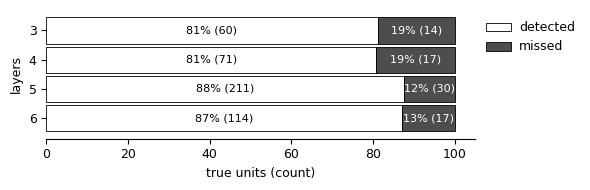

In [57]:
# count proportion of missed per layer
n_missed_per_layer = missed_data.groupby("layer").size()
n_total_per_layer = matching.groupby("layer").size()

# plot 
plot_miss_by_x(n_missed_per_layer, n_total_per_layer, "layers")
print("the layers present in the dataset are:", matching["layer"].unique())

In [54]:
matching

,true_unit,sorted_unit,oversplit,missed,layer,morph_class
0,19690,298.0,True,False,3,PYR
1,24768,NaN,False,True,3,PYR
2,37423,293.0,True,False,3,PYR
3,39862,293.0,True,False,3,PYR
4,45637,105.0,True,False,3,PYR
...,...,...,...,...,...,...
529,4216128,141.0,True,False,5,INT
530,4217493,241.0,True,False,5,INT
531,4221920,0.0,True,False,5,INT
532,4228700,56.0,True,False,5,INT


## Plot misses by morph

In [64]:
# add layer feature
matching = feateng.add_property(
    matching, data_conf, properties=["morph_class", "etype"]
)

In [65]:
matching

,true_unit,sorted_unit,oversplit,missed,morph_class,etype
0,19690,298.0,True,False,PYR,cADpyr
1,24768,NaN,False,True,PYR,cADpyr
2,37423,293.0,True,False,PYR,cADpyr
3,39862,293.0,True,False,PYR,cADpyr
4,45637,105.0,True,False,PYR,cADpyr
...,...,...,...,...,...,...
529,4216128,141.0,True,False,INT,cACint
530,4217493,241.0,True,False,INT,bAC
531,4221920,0.0,True,False,INT,cACint
532,4228700,56.0,True,False,INT,cACint


In [66]:
# get matching object
scores = get_SpikeInterface_matching_object(GT_SORTING_PATH, KS3_SORTING_PATH).agreement_scores

# get missed units
missed_units = get_missed_units(scores)
missed_data = matching[matching["true_unit"].isin(missed_units)]

# get detected units
detected_units = get_detected_units(scores)
detected_data = matching[matching["true_unit"].isin(detected_units)]

detected
missed
the layers present in the dataset are: ['PYR', 'INT']
Categories (2, object): ['INT', 'PYR']


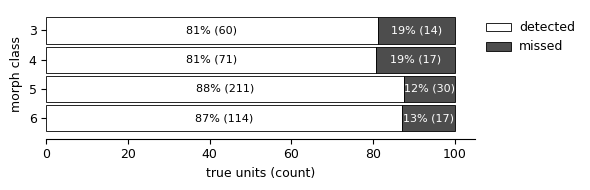

In [61]:
# count proportion of missed per morph_class
n_missed_by_morph = missed_data.groupby("morph_class").size()
n_total_by_morph = matching.groupby("morph_class").size()

# plot
plot_miss_by_x(n_missed_per_layer, n_total_per_layer, "morph class")
print("the layers present in the dataset are:", matching["morph_class"].unique())

detected
missed
the etype present in the dataset are: ['cADpyr', 'bAC', 'cACint', 'cNAC', 'bSTUT', 'bNAC', 'cSTUT', 'dNAC', 'dSTUT']
Categories (11, object): ['bAC', 'bIR', 'bNAC', 'bSTUT', ..., 'cNAC', 'cSTUT', 'dNAC', 'dSTUT']


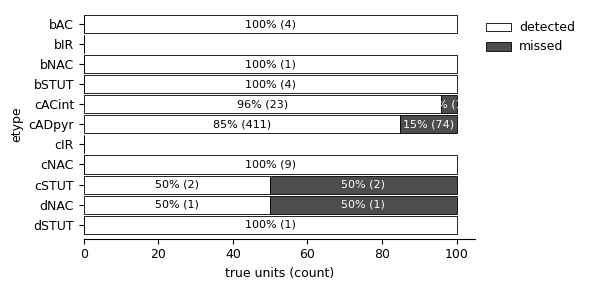

In [72]:
# count proportion of missed per morph_class
n_missed_by_etype = missed_data.groupby("etype").size()
n_total_by_etype = matching.groupby("etype").size()

# plot
plot_miss_by_x(n_missed_by_etype, n_total_by_etype, "etype", figsize=(6,2))
print("the etype present in the dataset are:", matching["etype"].unique())